In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd # read csv and manip tables 
import scipy.io #read .mat files
import statsmodels as sm
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR
from sklearn import preprocessing

In [2]:
# load cognitive variables
demog = pd.read_csv('adni2_weights_vbm_rs_model.csv',index_col=0)
print(demog.columns)
print('demog column shape: ',demog.columns.shape)

Index(['RID', 'gender', 'age', 'diagnosis', 'pt_group', 'APOE4',
       'APOE4_status', 'civet_exclude', 'mean_ct_wb', 'excluded', 'ctrlvsmci',
       'ctrlvsad', 'mcivsad', 'mtladni2sites', 'adni2', 'mean_gm', 'TIV', 'fd',
       'adni2site2', 'adni2site6', 'adni2site10', 'adni2site13', 'adni2site18',
       'adni2site19', 'adni2site31', 'adni2site53', 'adni2site100',
       'adni2site129', 'adni2site130', 'adni2site131', 'adni2site136', 'FDG',
       'AV45', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate',
       'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ',
       'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan',
       'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang',
       'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt',
       'EcogSPTotal', 'rs1_sub1', 'rs1_sub2', 'rs1_sub3', 'rs2_sub1',
       'rs2_sub2', 'rs2_sub3', 'rs3_sub1', 'rs3_sub2', 'rs3_sub3', 'rs4_sub1',
       'rs4_sub2', 'rs4_sub3', 

In [3]:
# Find NaN values of dependent variable
nan_cog = ~np.isnan(demog['MMSE'].values)
print('I found ',np.sum(~nan_cog),' NaN values out of ',nan_cog.shape[0],' entries')

I found  23  NaN values out of  190  entries


y shape: (167,)


(array([  7.,   7.,   2.,   2.,   6.,   9.,  17.,  13.,  27.,  77.]),
 array([ 19. ,  20.1,  21.2,  22.3,  23.4,  24.5,  25.6,  26.7,  27.8,
         28.9,  30. ]),
 <a list of 10 Patch objects>)

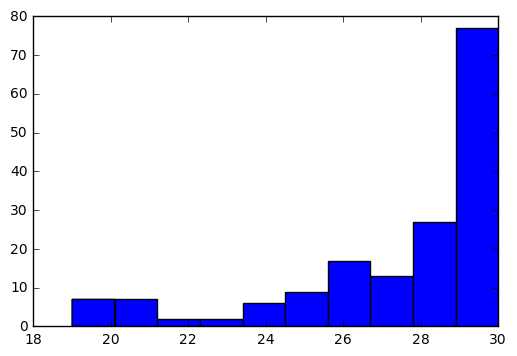

In [4]:
# Apply NaN filter
y = demog['MMSE'].values[nan_cog]
print('y shape:',y.shape)
plt.hist(y)

Mean after normalization:  -4.25474692072e-17
std after normalization:  1.0


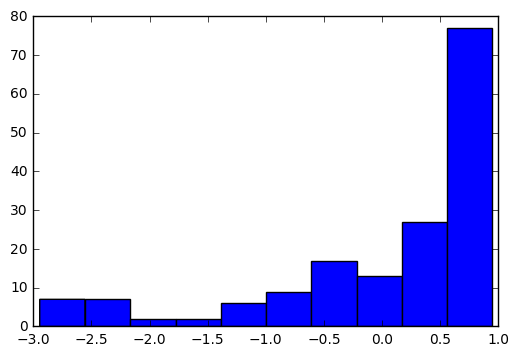

In [5]:
# Normalization
scl = preprocessing.StandardScaler()
y = scl.fit_transform(y.reshape(-1, 1))[:,0]
plt.hist(y)
print('Mean after normalization: ',np.mean(y))
print('std after normalization: ',np.std(y))

In [6]:
# Set the X to variables of interest
list_var = ['mean_ct_wb']
X = demog[list_var].values[nan_cog]
print('X shape:',X.shape)

X shape: (167, 1)


In [7]:
# remove rows with NaN values within X

# find the NaNs
nan_X = np.isnan(X)
print('nan_X:',nan_X.shape)

# sum the NaNs across rows/subjects
mask_nan = nan_X.sum(axis=1)

# make mask boolean
mask_nan = mask_nan != 0
print('mask_nan shape:',mask_nan.shape)

nan_X: (167, 1)
mask_nan shape: (167,)


y shape: (166,)
X shape: (166, 1)


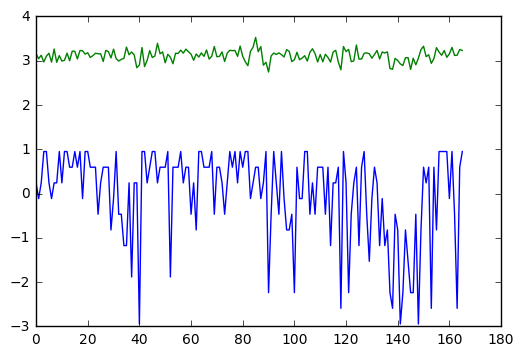

In [8]:
# apply the nan mask!

y = y[~mask_nan]
print('y shape:',y.shape)
plt.plot(y)

X = X[~mask_nan]
print('X shape:',X.shape)
plt.plot(X)

In [10]:
# init CV
scores = []
skf = KFold(n_splits=3)
for train_index, test_index in skf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train model
    #clf = SVR(kernel='linear', C=1e3)
    clf = SVR(kernel='rbf', C=1e1, gamma=0.1)
    
    # grid search cv
    clf = GridSearchCV(clf, cv=10,param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)})

    clf.fit(X_train, y_train)
    #sv_ratio = clf.best_estimator_.support_.shape[0] / (1.*len(y_train))
    #print("Support vector ratio: %.3f" % sv_ratio)
    
    # test
    scores.append(clf.score(X_test,y_test))
    print(scl.inverse_transform(clf.predict(X_test)))
    print(scores[-1])
    
print('Average R2: ', np.mean(scores))

[ 27.90864573  27.70636288  27.84880297  27.57468746  27.81243708
  27.92882462  27.56795396  28.1019723   27.55885188  27.83417562
  27.61144556  27.63961415  27.93477845  27.62372456  28.01589936
  28.00919941  27.6970347   28.04104589  28.0320092   27.89538761
  27.94916174  27.75862508  27.8314273   27.93166298  27.90976157
  27.90844647  27.5933331   28.05026323  27.9971517   27.73931934
  28.09767721  27.7101094   27.61225884  27.68131894  27.71933627
  28.1806384   27.86916916  27.98136547  27.86001333  27.3388278
  27.45221383  28.16429851  27.38566799  27.64244     28.03785023
  27.75467551  27.81766205  28.33535412  27.91002967  27.98484624
  27.5398447   27.88630832  27.76767469  27.49940362  27.93105799
  27.9220592 ]
-0.00189529645726
[ 28.59413054  28.38270266  28.66235699  28.470668    28.33931293
  27.89361728  28.34742819  28.2691237   28.3958656   28.29073894
  28.60661155  28.11028116  28.29257697  28.7288532   28.28063462
  28.29111935  28.45549378  27.50160222  28.